In [2]:
%%capture
!pip install torchsummary torchmetrics

# **Semanti Segmentation DeepLabV3 fine-tuning**

* Emanuele Masiero (872695)
* Simone Vendramini (866229)
* Tommaso Ferrario (869005)

[Competition Link](https://www.kaggle.com/competitions/open-cv-tf-project-3-image-segmentation-round-3)


Dataset:
> M. Rahnemoonfar, T. Chowdhury, A. Sarkar, D. Varshney, M. Yari and R. R. Murphy, "FloodNet: A High Resolution Aerial Imagery Dataset for Post Flood Scene Understanding," in IEEE Access, vol. 9, pp. 89644-89654, 2021, doi: 10.1109/ACCESS.2021.3090981.

## **Imports and Utils**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import os
import sys
import torch
import time

# Add the parent directory to the path so we can import the module
sys.path.append("/content/drive/MyDrive/Colab Notebooks/Progetto AML/src")

from Plots import plot_results
from torchsummary import summary
from Evaluation import Evaluation
from Utils import train, validate, train_finetuning, validate_finetuning
from torchvision import transforms
from torch.utils.data import DataLoader
from FloodNetDataset import FloodNetDataset
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [5]:
batch_size = 16

baseline_path = "/content/drive/MyDrive/Colab Notebooks/Progetto AML/FloodNet-Supervised_v2.0_compressed"

specific_path = {
    "train": {"img": "train_augmented/imgs", "label": "train_augmented/labels"},
    "val": {"img": "val/val-org-img", "label": "ColorMasks-ValSet"},
    "test": {"img": "test/test-org-img", "label": "ColorMasks-TestSet"},
}

## **Dataset Loading**

In [6]:
transform = transforms.Compose(
    [
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [7]:
train_data = FloodNetDataset(
    os.path.join(baseline_path, specific_path["train"]["label"]),
    os.path.join(baseline_path, specific_path["train"]["img"]),
    transform=transform,
    fine_tune=True
)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [8]:
val_data = FloodNetDataset(
    os.path.join(baseline_path, specific_path["val"]["label"]),
    os.path.join(baseline_path, specific_path["val"]["img"]),
    transform=transform,
    fine_tune=True
)

val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [9]:
test_data = FloodNetDataset(
    os.path.join(baseline_path, specific_path["test"]["label"]),
    os.path.join(baseline_path, specific_path["test"]["img"]),
    transform=transform,
    fine_tune=True
)

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## **Model**

In [10]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [11]:
model = model = deeplabv3_mobilenet_v3_large(weights="COCO_WITH_VOC_LABELS_V1").to(
    device
)
model

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:00<00:00, 147MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

In [11]:
# print number of paramiters
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

Number of parameters: 11,029,328


In [12]:
epochs = 10
num_classes = 10
learning_rate = 1e-3

In [13]:
# Freeze all the layers
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier with a new one, that has num_classes which is the number
# of classes in the dataset
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)

# Unfreeze the last layer
for param in model.classifier[4].parameters():
    param.requires_grad = True

model = model.to(device)

In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    train_loss, train_accuracy = train_finetuning(
        train_dataloader, model, criterion, optimizer, device
    )
    val_loss, val_accuracy = validate_finetuning(val_dataloader, model, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}:")
    print(
        f"\tTrain Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%"
    )
    print(f"\tVal Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")

Training Loss: 1.4479 | Training Acc: 0.4805
Validation Loss: 1.0836 | Validation Acc: 0.6256
Epoch 1/10:
	Train Loss: 1.4479, Train Accuracy: 48.05%
	Val Loss: 1.0836, Val Accuracy: 62.56%
Training Loss: 1.2910 | Training Acc: 0.5347
Validation Loss: 1.0534 | Validation Acc: 0.6258
Epoch 2/10:
	Train Loss: 1.2910, Train Accuracy: 53.47%
	Val Loss: 1.0534, Val Accuracy: 62.58%
Training Loss: 1.2508 | Training Acc: 0.5501
Validation Loss: 1.0193 | Validation Acc: 0.6435
Epoch 3/10:
	Train Loss: 1.2508, Train Accuracy: 55.01%
	Val Loss: 1.0193, Val Accuracy: 64.35%
Training Loss: 1.2317 | Training Acc: 0.5577
Validation Loss: 1.0047 | Validation Acc: 0.6506
Epoch 4/10:
	Train Loss: 1.2317, Train Accuracy: 55.77%
	Val Loss: 1.0047, Val Accuracy: 65.06%
Training Loss: 1.2107 | Training Acc: 0.5633
Validation Loss: 1.0051 | Validation Acc: 0.6553
Epoch 5/10:
	Train Loss: 1.2107, Train Accuracy: 56.33%
	Val Loss: 1.0051, Val Accuracy: 65.53%
Training Loss: 1.2098 | Training Acc: 0.5641
Valid

In [ ]:
# torch.save(model, 'model_deeplabv3_mobilenet_finetuned_ver2.pth')
# torch.save(model.state_dict(), 'model_deeplabv3_mobilenet_finetuned_ver2_dict.pth')

## **Model Evaluation**

In [ ]:
model = torch.load('model_deeplabv3_mobilenet_finetuned_ver2.pth', map_location=torch.device(device))

<ipython-input-22-563af46bb04f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/Colab Notebooks/Progetto AML/Models/model_deeplab

### Numerical Evaluation

In [ ]:
eval = Evaluation(model, test_dataloader, device)

In [ ]:
acc, dice, miou = eval.evaluate_model()
print(f"Accuracy: {acc * 100:.2f}%")
print(f"Dice Score: {dice * 100:.2f}%")
print(f"Mean IoU: {miou * 100:.2f}%")


Class occurrences in test set:
Class 0: 34 images
Class 1: 47 images
Class 2: 172 images
Class 3: 55 images
Class 4: 233 images
Class 5: 182 images
Class 6: 364 images
Class 7: 166 images
Class 8: 96 images
Class 9: 414 images
Accuracy: 67.36%
Dice Score: 64.62%
Mean IoU: 34.43%


### Visual Evaluation

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [ ]:
# Funzione per denormalizzare l'immagine
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1).to(device)
    std = torch.tensor(std).view(3, 1, 1).to(device)
    tensor = tensor * std + mean  # Inversa della normalizzazione
    tensor = torch.clamp(tensor * 255, 0, 255).byte()  # Riporta nel range [0, 255]
    return tensor

In [ ]:
def plot_network_results(loader, model):
    image, label = next(iter(loader))
    image, label = image.to(device), label.to(device)

    model.eval()
    with torch.no_grad():
        pred = model(image)['out']

    pred = pred.argmax(dim=1)

    image = denormalize(image, mean, std).to(device)

    for i in range(10):
        plot_results(image[i], pred[i].unsqueeze(0), label[i].unsqueeze(0))

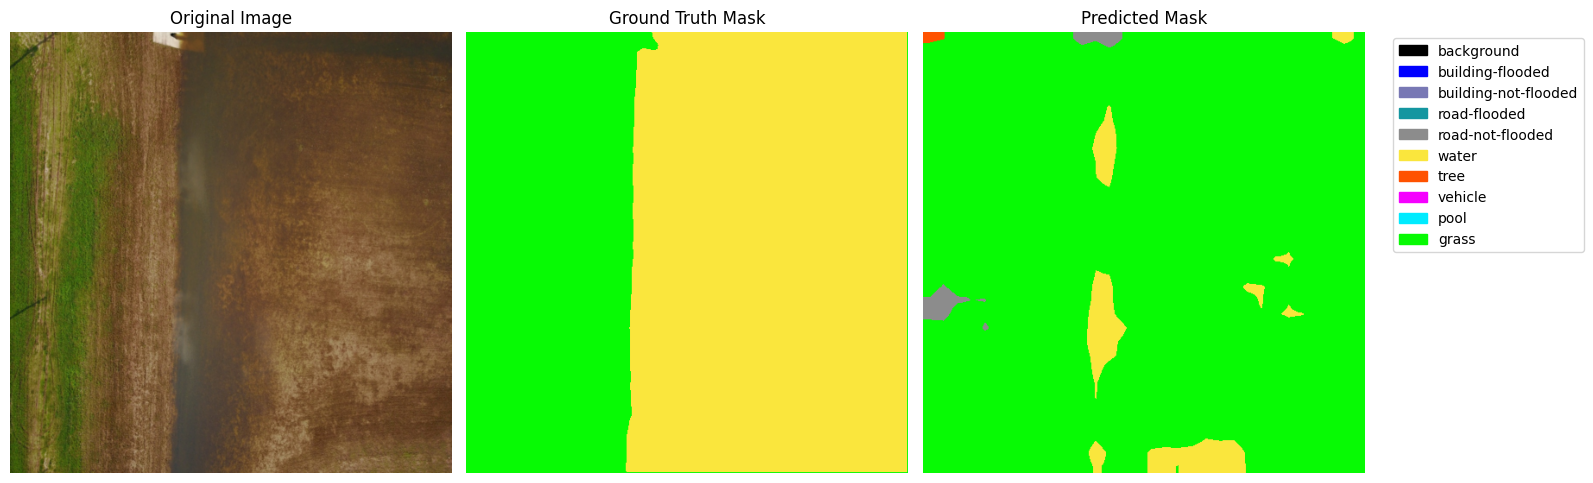

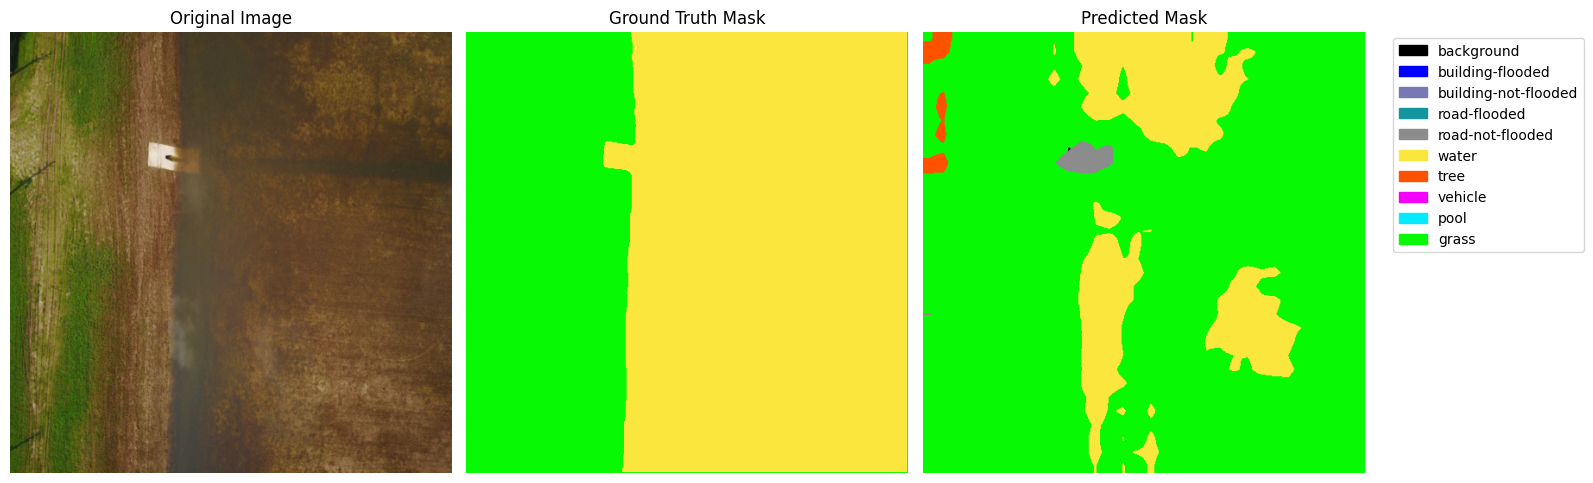

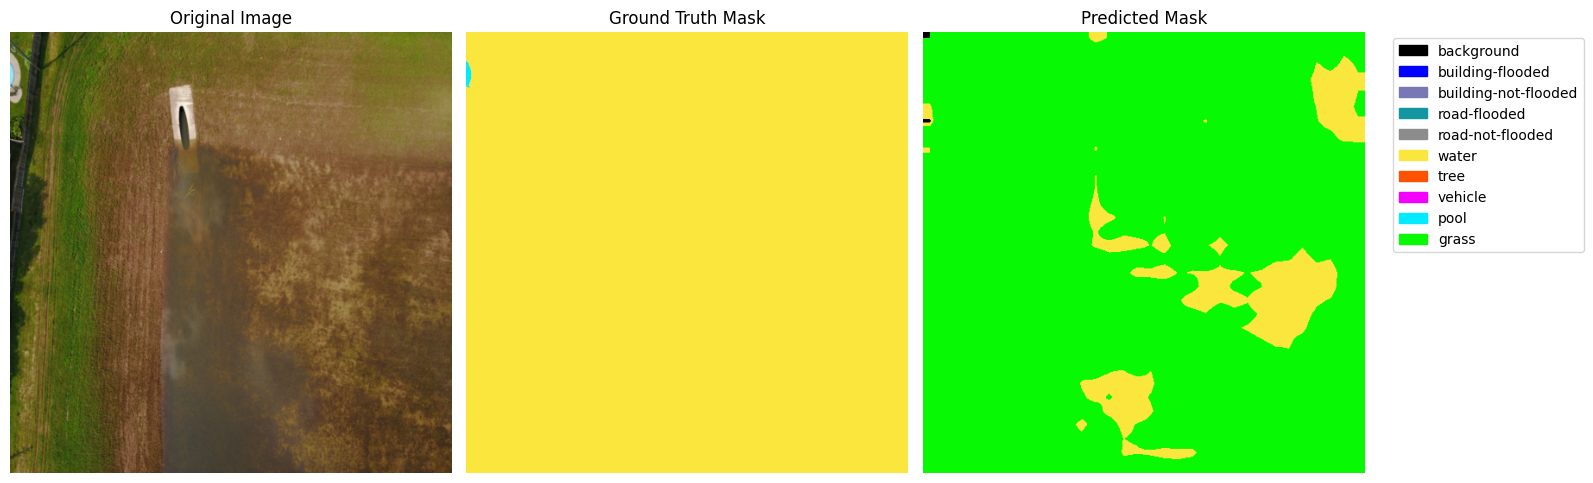

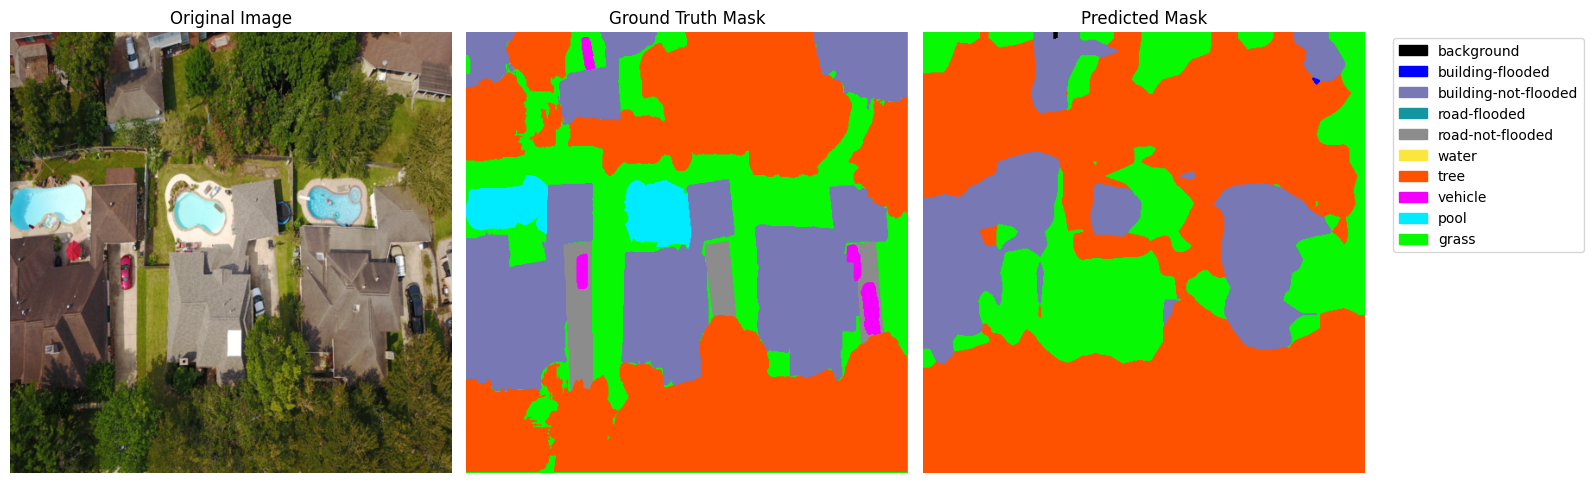

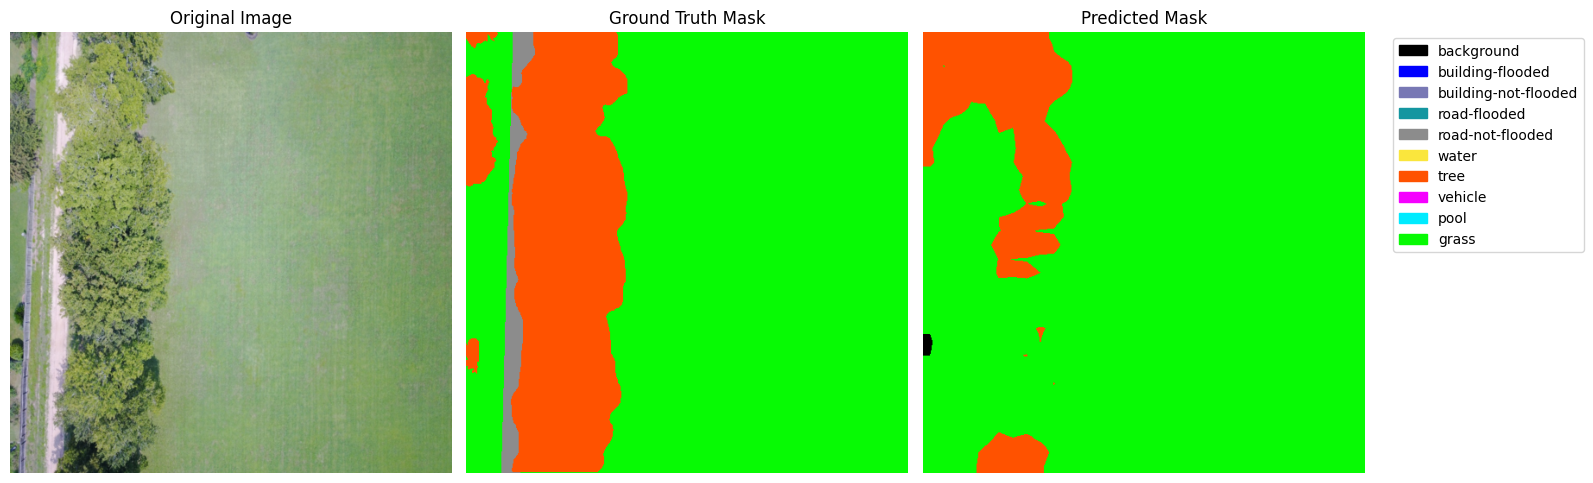

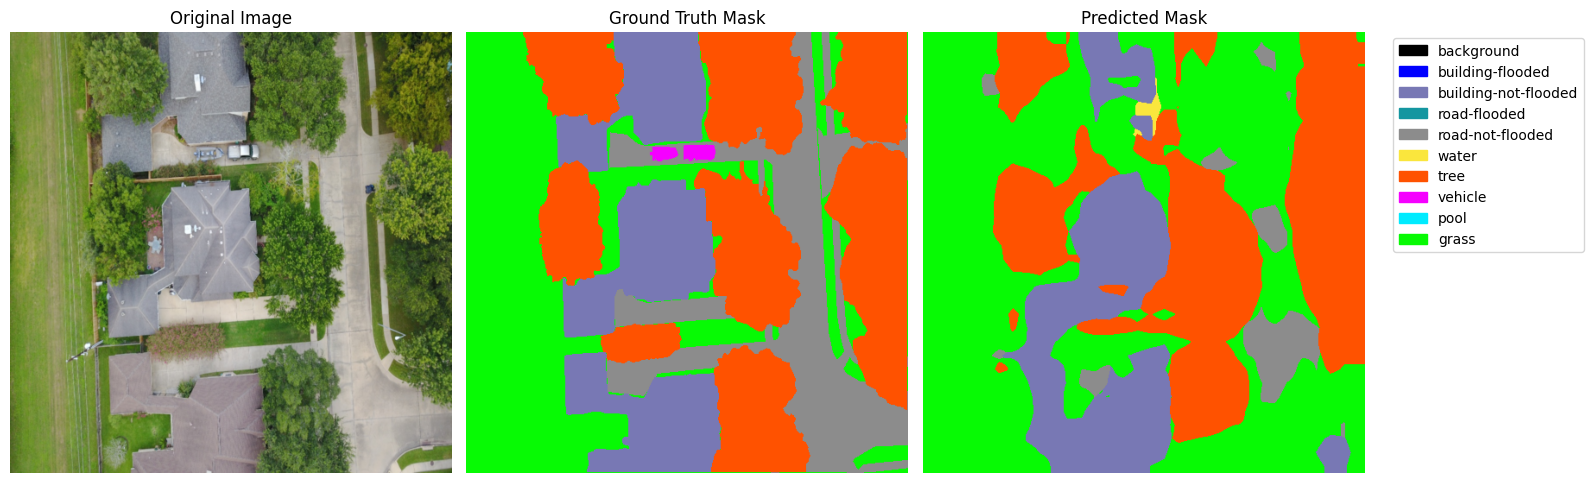

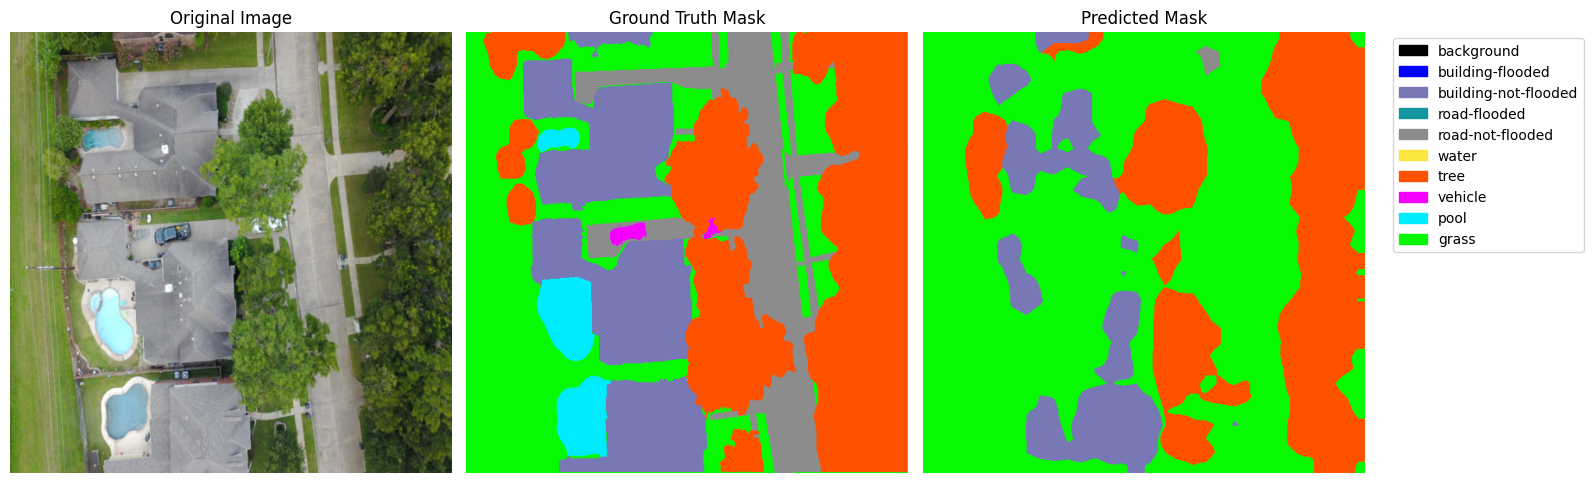

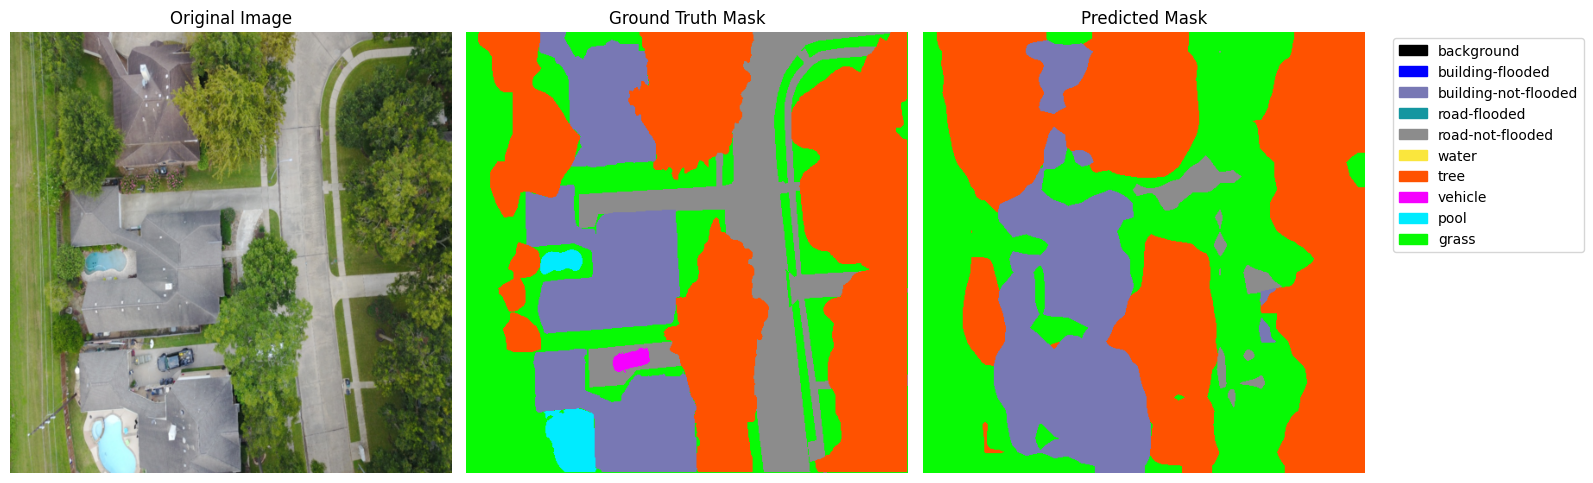

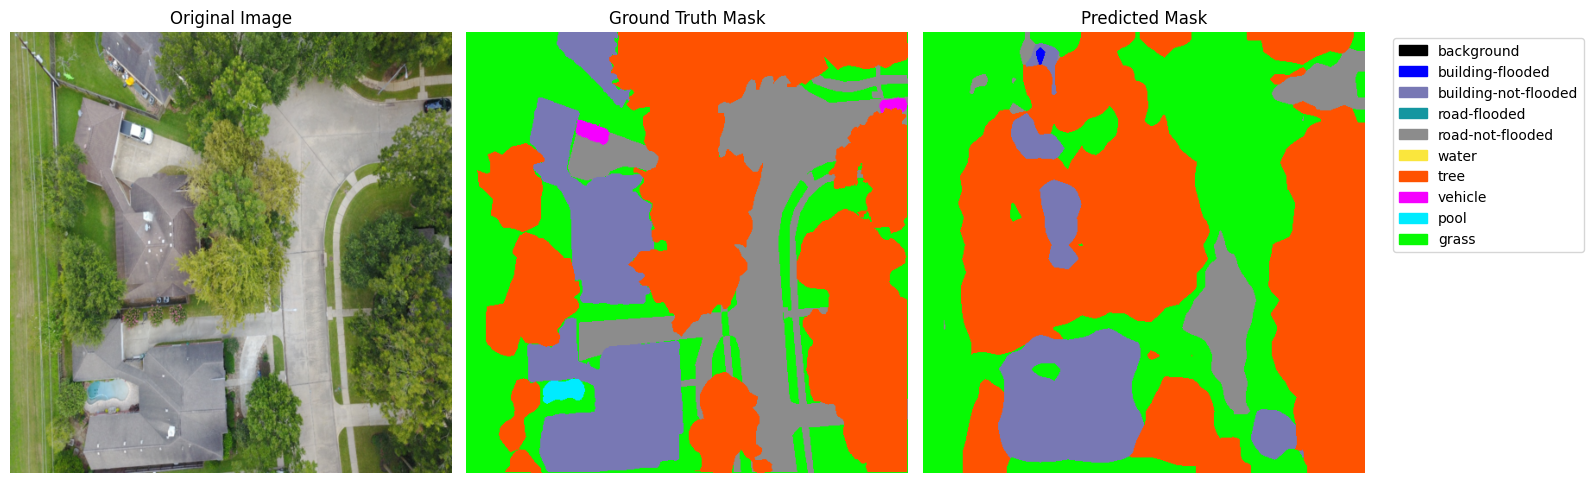

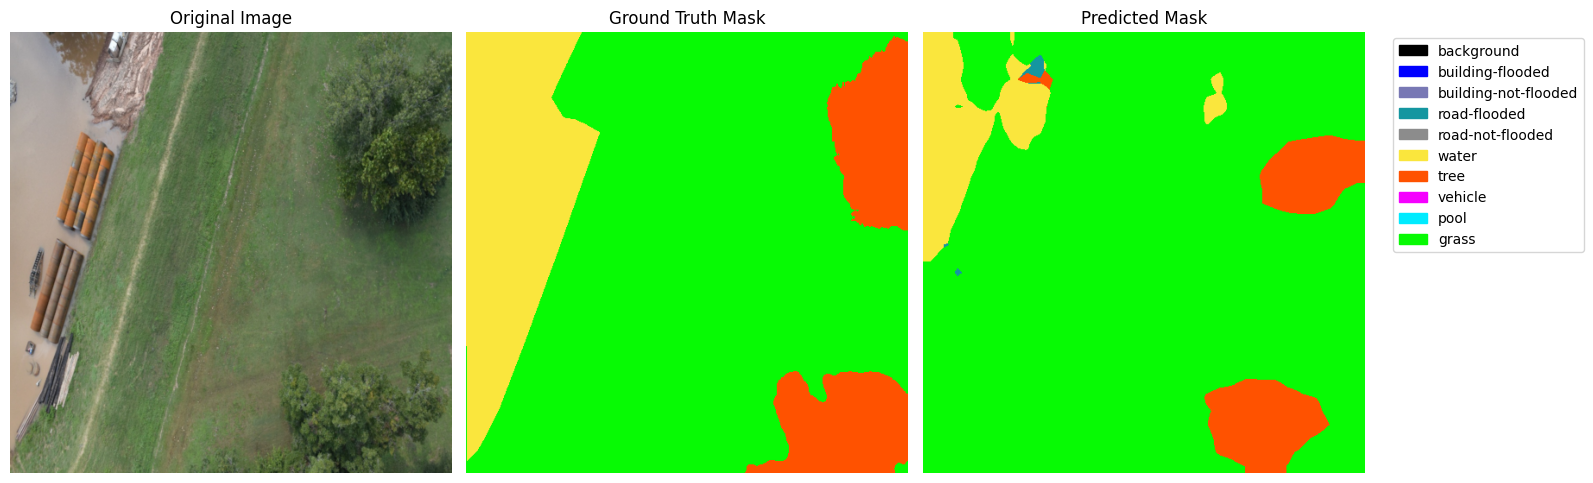

In [ ]:
plot_network_results(test_dataloader, model)